subsample the number of inidviduals and look at how number of signals changes

In [15]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns


prefix = '/home/klawren/oak/pcqtls'


### create the subsampled expression and covar files

In [31]:
# minimum of 300 in each tissue, I'll do 100, 200, 300

# get outputs from a config file
config_path= f'{prefix}/config/tami_clusters/proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']

tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Cells_Cultured_fibroblasts'

for num_samples in [75,150,250]:
    output_dir = f'{prefix}/data/processed/subsampling/{num_samples}'
    os.mkdir(output_dir)
    os.mkdir(f'{output_dir}/covariates/')
    os.mkdir(f'{output_dir}/normalized_expression/')

    for tissue_id in tissue_ids:
        # load in each expression and covariates files
        expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
        covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T

        selected_samples = covariates_df.index[:num_samples].values

        # write out first x as a subset
        sub_expression = expression_df[np.concatenate([expression_df.columns[:4].values, selected_samples])]
        sub_expression.to_csv(f'{output_dir}/normalized_expression/{tissue_id}.v8.normalized_expression.bed', sep='\t', index=None)

        sub_covar = covariates_df.loc[selected_samples]
        sub_covar.T.to_csv(f'{output_dir}/covariates/{tissue_id}.v8.covariates.txt', sep='\t')

I then run snakemake on each of these 4 to get the QTLs with config files in config/subsampling/

### Number QTLs across subsamples

In [16]:
# load in the configs for each 

sub_config = {}
for num_samples in [50,100,200,300]:
    pc_config_path= f'{prefix}/config/subsampling/{num_samples}_subsample.yaml'
    with open(pc_config_path, 'r') as f:
        pc_config = yaml.safe_load(f)
        sub_config[num_samples] = pc_config

tissue_id_path = pc_config['tissue_id_path']
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


tissue_id = 'Cells_Cultured_fibroblasts'

In [10]:
def get_qtl_counts(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']

def get_cluster_count(tissue_id, config):
    cluster_df = pd.read_csv('{}/{}/{}_clusters_all_chr.csv'.format(prefix, config['clusters_dir'], tissue_id))
    return len(cluster_df)

def get_egene_count(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    if len(overlap_df) == 0:
        return 0
    else:
        return len(set(np.concatenate(overlap_df['cluster_id'].str.split('_'))))

def get_counts(config):
    counts = tissue_df['Tissue'].apply(get_qtl_counts, args=(config,))
    counts = tissue_df.join(counts)
    counts['clusters'] = counts['Tissue'].apply(get_cluster_count, args=(config,))
    counts['egenes'] = counts['Tissue'].apply(get_egene_count, args=(config,))
    return counts

In [13]:
sub_counts = []
for num_samples in [50,100,200,300]:
    sub_counts.append(get_counts(sub_config[num_samples]))

In [29]:
sub_counts[1]

,Tissue,control_eqtl,pc_qtl,clusters,egenes
0,Adipose_Subcutaneous,2307,2326,683,1432
1,Adipose_Visceral_Omentum,2112,2157,615,1320
2,Artery_Tibial,1874,1904,547,1161
3,Cells_Cultured_fibroblasts,1862,1853,539,1162
4,Esophagus_Mucosa,1966,1999,572,1225
5,Esophagus_Muscularis,1626,1647,487,1028
6,Lung,2484,2519,719,1517
7,Muscle_Skeletal,1635,1677,475,997
8,Nerve_Tibial,2147,2178,632,1362
9,Skin_Not_Sun_Exposed_Suprapubic,2132,2175,606,1332


In [30]:
sub_counts[2]

,Tissue,control_eqtl,pc_qtl,clusters,egenes
0,Adipose_Subcutaneous,1131,893,951,1440
1,Adipose_Visceral_Omentum,958,779,955,1343
2,Artery_Tibial,1046,823,812,1287
3,Cells_Cultured_fibroblasts,1442,1115,818,1535
4,Esophagus_Mucosa,1009,767,802,1237
5,Esophagus_Muscularis,1065,812,774,1240
6,Lung,1125,908,1020,1455
7,Muscle_Skeletal,734,565,748,1006
8,Nerve_Tibial,1561,1191,985,1685
9,Skin_Not_Sun_Exposed_Suprapubic,1089,897,827,1405


In [33]:
joined_count_df = pd.concat(sub_counts, keys=[50,100,200,300], names=['num_samples', 'idx'])
joined_count_df.fillna(0, inplace=True)
joined_count_df.reset_index(level=0, inplace=True)
joined_counts = joined_count_df.melt(id_vars=['Tissue', 'num_samples'], var_name='count_type', value_name='count')

Text(0.5, 0.98, 'Subsampled counts')

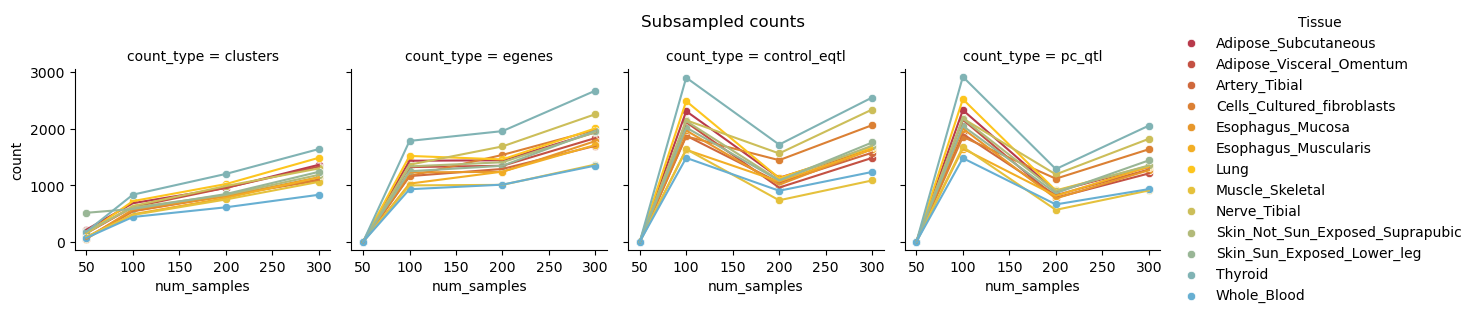

In [27]:
g = sns.FacetGrid(joined_counts, col="count_type", hue='Tissue', palette = tissue_pal)
g.map(sns.lineplot, "num_samples", "count")
g.map(sns.scatterplot, "num_samples", "count")
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Subsampled counts')